In [1]:
import random
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
import torch
import gym
from gym import spaces
from stable_baselines3 import A2C, PPO

random.seed(154012)
np.random.seed(154012)
torch.manual_seed(154012)

In [2]:
fc = 2.6 #2.6 GHz
bandwidth = 1e7 #10 MHz
temp = 40 + 273.15 # 40 celsius in kelvin
boltz = 1.381e-23
epsilon = 1e-7
row_bs = 4
col_bs = 4
mean_dist = 500
grid_width = mean_dist*(row_bs+1)
grid_height = mean_dist*(col_bs+1)
n_actions = 2

blackout_choices = np.array([
    [3*3600, 4*3600],
    [6*3600, 4*3600],
    [14*3600, 4*3600],
    [19*3600, 4*3600],
])

# blackout_choices = np.array([
#     [2*3600, 4*3600],
#     [7*3600, 4*3600],
#     [13*3600, 4*3600],
#     [19*3600, 4*3600],
# ])

baseline_times = [0]
baseline_times.extend([i[0] for i in blackout_choices])
baseline_times.extend([i[0]+i[1]+1 for i in blackout_choices])
baseline_times.sort()

bs_loc = np.mgrid[mean_dist: grid_width:mean_dist, mean_dist: grid_height:mean_dist]
bs_loc = bs_loc.reshape((2,-1)).T
bs_loc += mean_dist//10 - np.random.randint(0, 2*mean_dist//10, bs_loc.shape)

bs_power = np.array([40. for i in bs_loc])

print(bs_loc.shape)

bs_blackout = blackout_choices[np.random.randint(0,3, (row_bs*col_bs))]

(16, 2)


In [3]:
class EnvCluster(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, step_size=60,limit = 24*60*60):
        super(EnvCluster, self).__init__()
        self.bs_loc = bs_loc # locations of the base stations
        self.bs_power = 1*bs_power # current power values of the base stations
        self.electricity = np.zeros_like(bs_power) # current electricity state 0 have electricity, 1 blackout
        self.bs_blackout_start = bs_blackouts[:,0] # times which blackout starts for each base station
        self.bs_blackout_end = np.sum(bs_blackouts, axis=-1) # times which blackout ends for each base station
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.bitrate = []
        self.reward = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_bs = bs_power.shape[0]
        self.episode = 0
        self.limit = limit + 1
        self.step_size = step_size
        self.action_space = spaces.MultiBinary(self.n_bs)
        self.observation_space = spaces.MultiBinary(self.n_bs)

    def step(self, action):
        self.bulk_actions(action)
        reward = self.get_reward()
        self.episode += self.step_size
        self.apply_blackouts(self.episode)
        next_state = self.get_state() 
        done = self.episode > self.limit
        print("EPISODE_{:03d}, REWARD {}".format(self.episode, reward))
        return next_state, reward, done, dict()

    def make_action(self, actions):
        state = self.get_state()
        self.bulk_actions(actions)
        next_state = self.get_state() 
        reward = self.get_reward()
        return state, actions, next_state, reward

    def reset(self):
        self.apply_blackouts(0)
        self.apply_baseline()
        self.episode = 0
        self.get_reward()
        return self.get_state()

    def render(self, mode='human'):
        name = "log_bitrate_{:06d}.png".format(self.episode)
        plt.imsave(name, np.log(self.bitrate + epsilon), cmap = plt.cm.jet)

    def close(self):
        return super().close()
    
    def apply_blackouts(self, time):
        self.episode = time
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)

    def set_action(self, bs_index, action):
        self.bs_power[bs_index] = self.actions[action]
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance):
        return 35*np.log10(distance+1) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self, powers):
        max_power = self.dbm_to_watt(powers.max(axis=-1))
        interference_power = self.dbm_to_watt(powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        # total_points = self.grid_height * self.grid_width
        total_points = b_rate.shape[0]*b_rate.shape[1]

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        max_speed = b_rate.max()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points , min_speed, max_speed

    def get_reward(self):
        constant = 20
        br_cost = 0
        max_cost = 0
        min_cost = 10000 # just arbitrary large number


        # fixed number of point despite the width height
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_width, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        self.bitrate = bit_rate
        percentage, min_speed_cost, max_speed = self.bit_rate_cost_function(bit_rate)
        br_cost += percentage
        min_cost = min(min_cost, min_speed_cost)
        max_cost = max(max_cost, max_speed)

        # print(self.electricity.shape)
        # print(self.dbm_to_watt(self.bs_power))
        disparity = (max_cost - min_cost + 0.01)/ (max_cost + 0.0001) * 10
        elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
        r = constant - br_cost + min_cost - disparity - elec_cost
        # print("br", -br_cost)
        # print("min cost", min_cost )
        # print("disparity", -disparity)
        # print("elec cost", elec_cost)
        # print("r", r)
        
        return r
    
    def get_state(self):
        return 1 - 1*self.electricity

    def baseline_action(self, bs_index):
        if self.electricity[bs_index]:
            self.set_action(bs_index, 0)
        else:
            self.set_action(bs_index, self.n_actions-1)

    def bulk_actions(self, actions):
        actions = np.round_(actions)
        actions = actions.astype(int)
        # print(actions)
        self.bs_power = self.actions[actions]

    def apply_baseline(self):
        self.bulk_actions((1 - self.electricity)*(self.n_actions-1))
    
    def plot_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], np.log(bit_rate + epsilon), 100, cmap = plt.cm.jet)

    def save_bit_rate_plot(self, index=None):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        # plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        # if not index:
        #     plt.savefig('bitrate.png')
        # else:
        #     name = "bitrate_{:06d}.png".format(index)
        #     plt.savefig(name)
        if index == None:
            plt.imsave('log_bitrate.png', np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig('log_bitrate.png')
        else:
            name = "log_bitrate_{:06d}.png".format(index)
            plt.imsave(name, np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig(name)
        
    def plot_watt_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], self.dbm_to_watt(power_grid[:,:,index]), 100, cmap = plt.cm.jet)
        
    def plot_dbm_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], power_grid[:,:,index], 100, cmap = plt.cm.jet)

In [7]:
env = EnvCluster(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height,step_size=3*60*30+1)
# check_env(env)


<ipython-input-3-70d69f00314b>:66: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


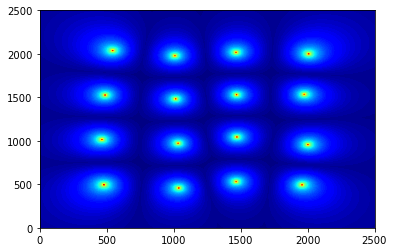

In [8]:
env.plot_bit_rate()

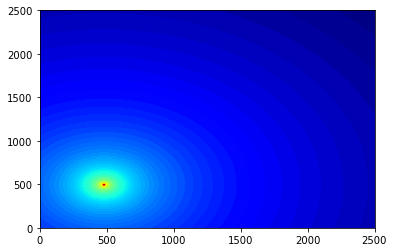

In [9]:
env.plot_dbm_power_grid(0)

In [10]:
done = False

obs = env.reset()
while not done:
    obs, rewards, done, info = env.step(obs)
    print(obs, rewards)
    env.render()

obs = env.reset()

EPISODE_5401, REWARD 3.3745464153966314
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 3.3745464153966314
EPISODE_10802, REWARD 3.3745464153966314
[1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1] 3.3745464153966314
EPISODE_16203, REWARD 3.564994224355077
[1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1] 3.564994224355077
EPISODE_21604, REWARD 3.564994224355077
[0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0] 3.564994224355077
EPISODE_27005, REWARD 4.325851755406276
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0] 4.325851755406276
EPISODE_32406, REWARD 3.193186016315641
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0] 3.193186016315641
EPISODE_37807, REWARD 3.193186016315641
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 3.193186016315641
EPISODE_43208, REWARD 3.3745464153966314
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 3.3745464153966314
EPISODE_48609, REWARD 3.3745464153966314
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 3.3745464153966314
EPISODE_54010, REWARD 3.3745464153966314
[1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1] 3.3745464153966314
EPISODE_59411, REWARD 3.8016206830824704
[1 0 1 0 1 1 0 1 0 1 1 0 1 0 1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
timestamps = 20000
lr = 0.0007

In [6]:
model = A2C("MlpPolicy", env, learning_rate=lr, verbose=3)
model.set_parameters(load_path_or_dict="a2c")
model.learn(timestamps)
model.save("a2c")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
EPISODE_5401, REWARD 4.208271621643782
EPISODE_10802, REWARD 4.208271621643782
EPISODE_16203, REWARD -6.432097236590549
EPISODE_21604, REWARD 4.208271621643782
EPISODE_27005, REWARD 4.208271621643782
EPISODE_32406, REWARD 4.012963037999217
EPISODE_37807, REWARD 4.208271621643782
EPISODE_43208, REWARD 4.208271621643782
EPISODE_48609, REWARD 3.843003296179649
EPISODE_54010, REWARD 3.345392397219479
EPISODE_59411, REWARD 3.426084849955833
EPISODE_64812, REWARD 3.9891914878411647
EPISODE_70213, REWARD 3.7106944459997546
EPISODE_75614, REWARD 4.208271621643782
EPISODE_81015, REWARD 4.208271621643782
EPISODE_86416, REWARD 3.6370099813753978
EPISODE_5401, REWARD 4.285746710234356
EPISODE_10802, REWARD 4.675536186652449
EPISODE_16203, REWARD 4.208271621643782
EPISODE_21604, REWARD 4.208271621643782
EPISODE_27005, REWARD 4.208271621643782
EPISODE_32406, REWARD 4.579495552297274
EPISODE_37807, REWARD 2.

In [7]:
model = A2C("MlpPolicy", env, learning_rate=lr, verbose=3)
model.set_parameters(load_path_or_dict="a2c")
model.learn(timestamps)
model.save("a2c")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
EPISODE_5401, REWARD 4.639982785141905
EPISODE_10802, REWARD 4.4857356418886685
EPISODE_16203, REWARD 3.323736907426362
EPISODE_21604, REWARD 4.142324201725851
EPISODE_27005, REWARD 4.208271621643782
EPISODE_32406, REWARD 4.208271621643782
EPISODE_37807, REWARD 4.208271621643782
EPISODE_43208, REWARD 3.6652179037945203
EPISODE_48609, REWARD 4.042298877266726
EPISODE_54010, REWARD 3.478829906884247
EPISODE_59411, REWARD 3.2432500721669317
EPISODE_64812, REWARD 4.042298877266726
EPISODE_70213, REWARD 4.639982785141905
EPISODE_75614, REWARD 4.4857356418886685
EPISODE_81015, REWARD 4.042298877266726
EPISODE_86416, REWARD 4.042298877266726
EPISODE_5401, REWARD 3.7182374306569574
EPISODE_10802, REWARD 3.478829906884247
EPISODE_16203, REWARD 4.208271621643782
EPISODE_21604, REWARD 4.208271621643782
EPISODE_27005, REWARD 4.208271621643782
EPISODE_32406, REWARD 4.208271621643782
EPISODE_37807, REWARD 4

In [5]:
model = A2C.load("a2c")
model.set_parameters(load_path_or_dict="a2c")
done = False

obs = env.reset()
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    print(obs, action)
    env.render()

EPISODE_5401, REWARD 4.208271621643782
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_10802, REWARD 4.208271621643782
[1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_16203, REWARD 4.208271621643782
[1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_21604, REWARD 4.208271621643782
[0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_27005, REWARD 4.208271621643782
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_32406, REWARD 4.208271621643782
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_37807, REWARD 4.208271621643782
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_43208, REWARD 4.208271621643782
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
EPISODE_4

In [9]:
batch_size = 128
n_steps = 2*batch_size
model = PPO("MlpPolicy", env, learning_rate=lr, n_steps=n_steps, batch_size=batch_size, verbose=2)
model.set_parameters(load_path_or_dict="ppo")
model.learn(timestamps)
model.save("ppo")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
EPISODE_5401, REWARD 3.7968241534409906
EPISODE_10802, REWARD 4.6784039286062615
EPISODE_16203, REWARD 4.795181249472778
EPISODE_21604, REWARD 4.884346985536265
EPISODE_27005, REWARD 4.675536186652449
EPISODE_32406, REWARD 4.795181249472778
EPISODE_37807, REWARD 4.675536186652449
EPISODE_43208, REWARD 4.705274628424931
EPISODE_48609, REWARD 4.152735954811842
EPISODE_54010, REWARD 4.11726037632498
EPISODE_59411, REWARD 3.3648614154659207
EPISODE_64812, REWARD 4.196669432814037
EPISODE_70213, REWARD 4.549948039534305
EPISODE_75614, REWARD 4.151925083111516
EPISODE_81015, REWARD 3.7917351066368763
EPISODE_86416, REWARD 4.1398102524479405
EPISODE_5401, REWARD 5.22211726609072
EPISODE_10802, REWARD 4.27866905950558
EPISODE_16203, REWARD 4.675536186652449
EPISODE_21604, REWARD 4.675536186652449
EPISODE_27005, REWARD 4.325851755406276
EPISODE_32406, REWARD 4.675536186652449
EPISODE_37807, REWARD 4.21

In [10]:
model = PPO.load("ppo")
model.set_parameters(load_path_or_dict="ppo")
done = False

obs = env.reset()
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    print(rewards, action)
    env.render()

EPISODE_5401, REWARD 5.021026547710454
5.021026547710454 [1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
EPISODE_10802, REWARD 5.651210884114612
5.651210884114612 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
EPISODE_16203, REWARD 4.884346985536265
4.884346985536265 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
EPISODE_21604, REWARD 4.675536186652449
4.675536186652449 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
EPISODE_27005, REWARD 4.675536186652449
4.675536186652449 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
EPISODE_32406, REWARD 4.675536186652449
4.675536186652449 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
EPISODE_37807, REWARD 4.675536186652449
4.675536186652449 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
EPISODE_43208, REWARD 5.651210884114612
5.651210884114612 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
EPISODE_48609, REWARD 5.069438107514896
5.069438107514896 [1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
EPISODE_54010, REWARD 5.65121